## Coding Project [Part 5] - Numerical Integration Comparison With Existing Solutions
### Author: Paras Sharma

In [77]:
import lenstronomy
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.LensModel.lens_model import LensModel
# multivariable numerical integration
from scipy.integrate import dblquad

#### 1.  Defining the Lens Model

Text(0, 0.5, 'y [arcsec]')

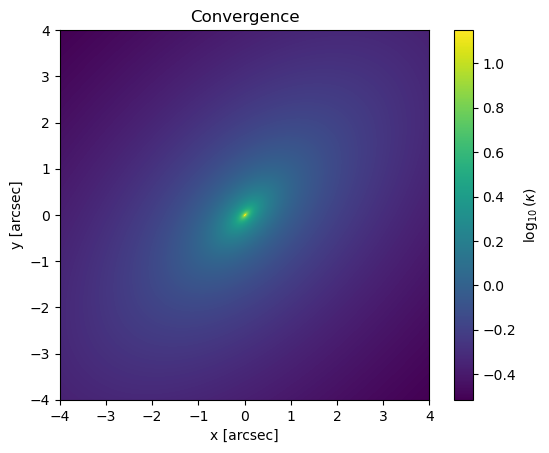

In [78]:
# Define the lens model - EPL + SHEAR

lens_model = LensModel(lens_model_list=[
                                        'EPL', 
                                        # 'SHEAR',
                                        # 'NFW'
                                        ])

kwargs_lens = [
    {'theta_E': 1.8, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0, 'gamma': 1.58}, # EPL
#   {'gamma1': 0.03, 'gamma2': 0} # shear
    # {"Rs":1, "alpha_Rs":1, "center_x":0, "center_y":0} # NFW
               ]

x_grid, y_grid = np.linspace(-4, 4, 400), np.linspace(-4, 4, 400)
x_coords, y_coords = np.meshgrid(x_grid, y_grid)

kappa_on_grid = lens_model.kappa(x_coords, y_coords, kwargs_lens)

plt.figure()
plt.title('Convergence')
plt.imshow(np.log10(kappa_on_grid), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)], 
           origin='lower')
c = plt.colorbar()
c.set_label('$\\log_{10}(\\kappa)$')
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')


#### 2. Numerical Integration to find the deflection angle and the lensing potential

The deflection angle $\alpha$, the lensing potential $\psi$ and the convergence $\kappa$ are related by the following equations:
$$\alpha = \nabla \psi$$
$$\kappa = \frac{1}{2} \nabla^2 \psi \Rightarrow \nabla \alpha = 2 \kappa$$

By taking the Fourier transform of the above equation, we get:
$$\mathcal{F}[\psi (\vec{\theta})](\vec{k}) = -\frac{2}{k^2} \mathcal{F}[\kappa (\vec{\theta})](\vec{k}) \Rightarrow \psi (\vec{\theta}) = -\mathcal{F}^{-1} \left[ \frac{2}{k^2} \mathcal{F}[\kappa (\vec{\theta})](\vec{k}) \right]$$

The deflection angle, $\alpha$ and the lensing potential, $\psi$ can be calculated from the convergence, $\kappa$ using the following equations:
$$\vec{\alpha} (\vec{\theta}) = \frac{1}{\pi} \int \kappa (\vec{\theta'}) \frac{\vec{\theta} - \vec{\theta'}}{|\vec{\theta} - \vec{\theta'}|^2} d^2 \theta'$$
$$\psi (\vec{\theta}) = \frac{1}{\pi} \int \kappa (\vec{\theta'}) \ln |\vec{\theta} - \vec{\theta'}| d^2 \theta'$$

Note that the deflection angle can be written as convolution of the convergence with a kernel function. The lensing potential can be written as a convolution of the convergence with a different kernel function as
$$\vec{\alpha} (\vec{\theta}) = \frac{1}{\pi} \ \kappa * \left( \frac{\vec{\theta}}{|\vec{\theta}|^2} \right)$$
$$\psi (\vec{\theta}) = \frac{1}{\pi} \ \kappa * \left( \ln |\vec{\theta}| \right)$$



In [79]:
def lensing_potential_with_fft(x_coords, y_coords, kappa_on_grid):
    # first make the grid in Fourier space
    delta_x = x_coords[0, 1] - x_coords[0, 0]
    delta_y = y_coords[1, 0] - y_coords[0, 0]
    k_x = np.fft.fftfreq(x_coords.shape[1], delta_x)
    k_y = np.fft.fftfreq(y_coords.shape[0], delta_y)
    k_x_grid, k_y_grid = np.meshgrid(k_x, k_y)
    k_sq_grid = k_x_grid**2 + k_y_grid**2
    k_sq_grid[0, 0] = 1  # avoid division by zero

    # FFT of the convergence
    kappa_fft = np.fft.fft2(kappa_on_grid)

    # lensing potential in Fourier space
    phi_fft = -2 * kappa_fft / k_sq_grid

    # inverse FFT to real space
    phi_on_grid = np.fft.ifft2(phi_fft).real

    return phi_on_grid

def alpha_from_potential(phi_on_grid, x_coords, y_coords):
    alpha_x = np.gradient(phi_on_grid, axis=1) / (x_coords[0, 1] - x_coords[0, 0])
    alpha_y = np.gradient(phi_on_grid, axis=0) / (y_coords[1, 0] - y_coords[0, 0])
    return alpha_x, alpha_y

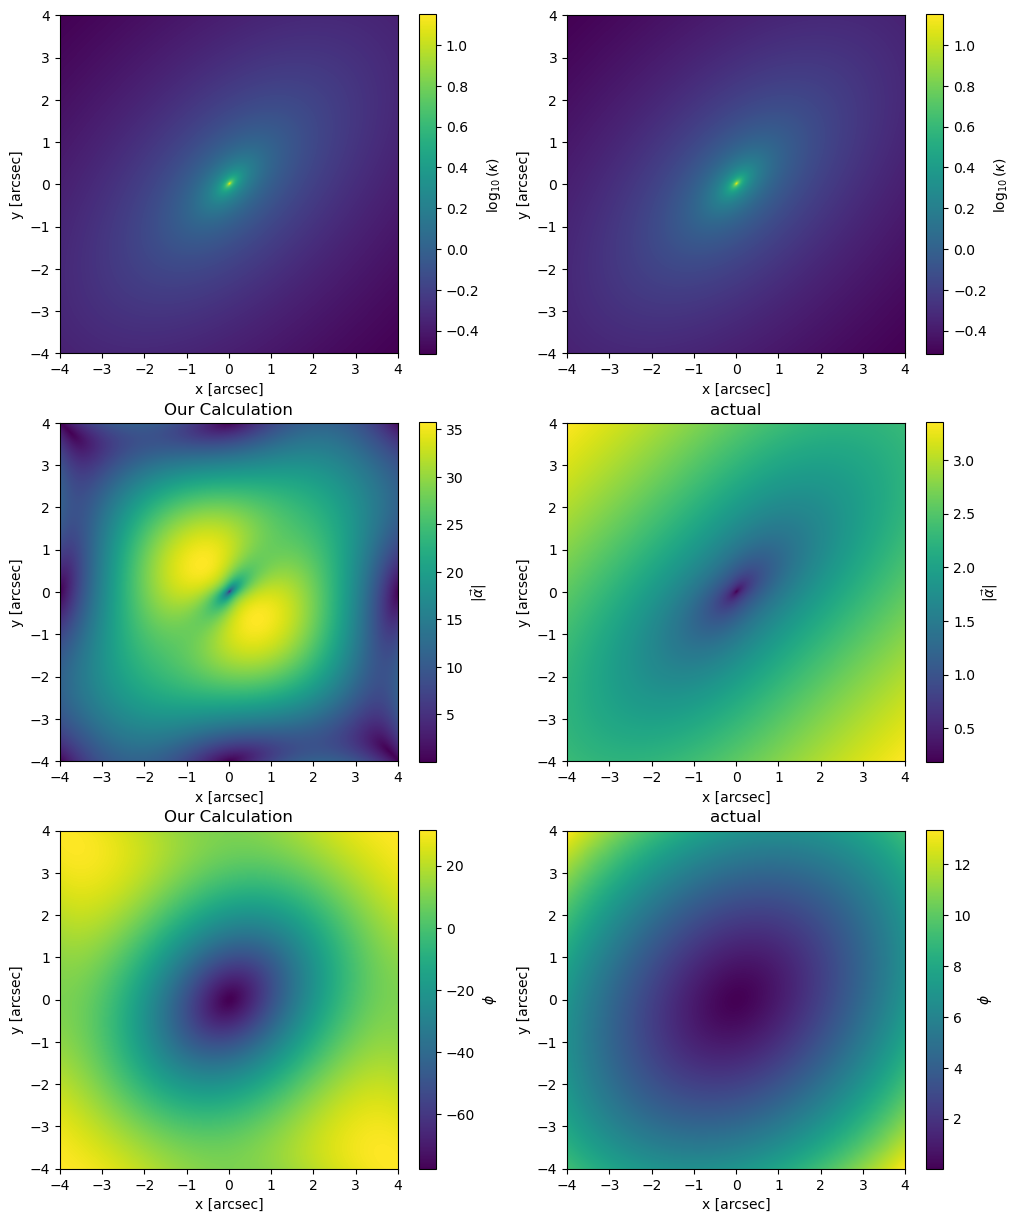

In [80]:
phi = lensing_potential_with_fft(x_coords, y_coords, kappa_on_grid)

alpha_x, alpha_y = alpha_from_potential(phi, x_coords, y_coords)

fig, ax = plt.subplots(3, 2, figsize=(12, 15))

# Convergence
# ax[0, 0].set_title('Our Calculation')
# ax[0, 1].set_title('actual')
ax[0, 0].imshow(np.log10(kappa_on_grid), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)], 
                origin='lower')
ax[0, 1].imshow(np.log10(kappa_on_grid), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[0, 0].set_xlabel('x [arcsec]')
ax[0, 0].set_ylabel('y [arcsec]')
ax[0, 1].set_xlabel('x [arcsec]')
ax[0, 1].set_ylabel('y [arcsec]')
c = ax[0, 0].figure.colorbar(ax[0, 0].images[0], ax=ax[0, 0])
c.set_label('$\\log_{10}(\\kappa)$')
c = ax[0, 1].figure.colorbar(ax[0, 1].images[0], ax=ax[0, 1])
c.set_label('$\\log_{10}(\\kappa)$')

# Deflection angles
lenstronomy_alpha_x, lenstronomy_alpha_y = lens_model.alpha(x_coords, y_coords, kwargs_lens)
ax[1, 0].set_title('Our Calculation')
ax[1, 1].set_title('actual')
ax[1, 0].imshow(np.sqrt(alpha_x**2 + alpha_y**2), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[1, 1].imshow(np.sqrt(lenstronomy_alpha_x**2 + lenstronomy_alpha_y**2), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[1, 0].set_xlabel('x [arcsec]')
ax[1, 0].set_ylabel('y [arcsec]')
ax[1, 1].set_xlabel('x [arcsec]')
ax[1, 1].set_ylabel('y [arcsec]')
c = ax[1, 0].figure.colorbar(ax[1, 0].images[0], ax=ax[1, 0])
c.set_label('$|\\vec{\\alpha}|$')
c = ax[1, 1].figure.colorbar(ax[1, 1].images[0], ax=ax[1, 1])
c.set_label('$|\\vec{\\alpha}|$')   

# Lensing potential
ax[2, 0].set_title('Our Calculation')
ax[2, 1].set_title('actual')
ax[2, 0].imshow(phi, extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)], 
                origin='lower')
ax[2, 1].imshow(lens_model.potential(x_coords, y_coords, kwargs_lens), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[2, 0].set_xlabel('x [arcsec]')
ax[2, 0].set_ylabel('y [arcsec]')
ax[2, 1].set_xlabel('x [arcsec]')
ax[2, 1].set_ylabel('y [arcsec]')
c = ax[2, 0].figure.colorbar(ax[2, 0].images[0], ax=ax[2, 0])
c.set_label('$\\phi$')
c = ax[2, 1].figure.colorbar(ax[2, 1].images[0], ax=ax[2, 1])
c.set_label('$\\phi$')

We see deviations from the analytical solution at the edges of the grid. This is due to the fact that the numerical integration is not able to capture the behaviour of the function at the edges of the grid. The EPL power law is slowly varying and does not die out fast enough before reaching the edges of the grid.

#### 3.  Try again with a steeper power law

Text(0, 0.5, 'y [arcsec]')

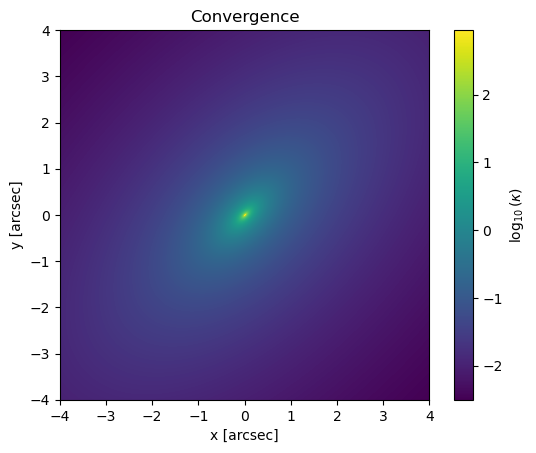

In [81]:
# Define the lens model - EPL + SHEAR

lens_model = LensModel(lens_model_list=[
                                        'EPL', 
                                        # 'SHEAR',
                                        # 'NFW'
                                        ])

kwargs_lens = [
    {'theta_E': 1.8, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0, 'gamma': 2.9}, # EPL
#   {'gamma1': 0.03, 'gamma2': 0} # shear
    # {"Rs":1, "alpha_Rs":1, "center_x":0, "center_y":0} # NFW

               ]

x_grid, y_grid = np.linspace(-4, 4, 400), np.linspace(-4, 4, 400)
x_coords, y_coords = np.meshgrid(x_grid, y_grid)

kappa_on_grid = lens_model.kappa(x_coords, y_coords, kwargs_lens)

plt.figure()
plt.title('Convergence')
plt.imshow(np.log10(kappa_on_grid), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)], 
           origin='lower')
c = plt.colorbar()
c.set_label('$\\log_{10}(\\kappa)$')
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')


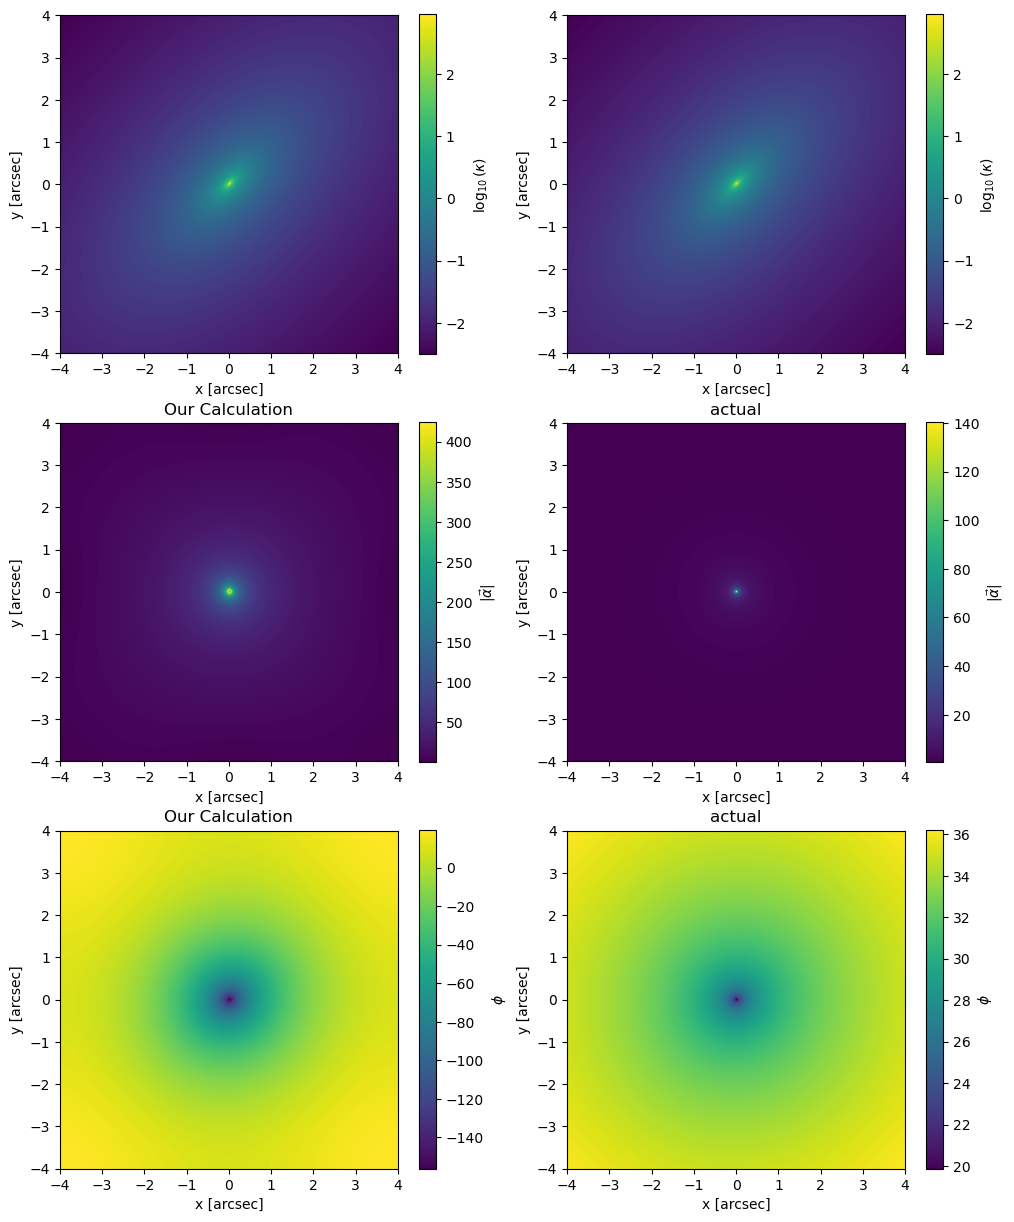

In [83]:
phi = lensing_potential_with_fft(x_coords, y_coords, kappa_on_grid)

alpha_x, alpha_y = alpha_from_potential(phi, x_coords, y_coords)

fig, ax = plt.subplots(3, 2, figsize=(12, 15))

# Convergence
# ax[0, 0].set_title('Our Calculation')
# ax[0, 1].set_title('actual')
ax[0, 0].imshow(np.log10(kappa_on_grid), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)], 
                origin='lower')
ax[0, 1].imshow(np.log10(kappa_on_grid), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[0, 0].set_xlabel('x [arcsec]')
ax[0, 0].set_ylabel('y [arcsec]')
ax[0, 1].set_xlabel('x [arcsec]')
ax[0, 1].set_ylabel('y [arcsec]')
c = ax[0, 0].figure.colorbar(ax[0, 0].images[0], ax=ax[0, 0])
c.set_label('$\\log_{10}(\\kappa)$')
c = ax[0, 1].figure.colorbar(ax[0, 1].images[0], ax=ax[0, 1])
c.set_label('$\\log_{10}(\\kappa)$')

# Deflection angles
lenstronomy_alpha_x, lenstronomy_alpha_y = lens_model.alpha(x_coords, y_coords, kwargs_lens)
ax[1, 0].set_title('Our Calculation')
ax[1, 1].set_title('actual')
ax[1, 0].imshow(np.sqrt(alpha_x**2 + alpha_y**2), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[1, 1].imshow(np.sqrt(lenstronomy_alpha_x**2 + lenstronomy_alpha_y**2), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[1, 0].set_xlabel('x [arcsec]')
ax[1, 0].set_ylabel('y [arcsec]')
ax[1, 1].set_xlabel('x [arcsec]')
ax[1, 1].set_ylabel('y [arcsec]')
c = ax[1, 0].figure.colorbar(ax[1, 0].images[0], ax=ax[1, 0])
c.set_label('$|\\vec{\\alpha}|$')
c = ax[1, 1].figure.colorbar(ax[1, 1].images[0], ax=ax[1, 1])
c.set_label('$|\\vec{\\alpha}|$')   

# Lensing potential
ax[2, 0].set_title('Our Calculation')
ax[2, 1].set_title('actual')
ax[2, 0].imshow(phi, extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)], 
                origin='lower')
ax[2, 1].imshow(lens_model.potential(x_coords, y_coords, kwargs_lens), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[2, 0].set_xlabel('x [arcsec]')
ax[2, 0].set_ylabel('y [arcsec]')
ax[2, 1].set_xlabel('x [arcsec]')
ax[2, 1].set_ylabel('y [arcsec]')
c = ax[2, 0].figure.colorbar(ax[2, 0].images[0], ax=ax[2, 0])
c.set_label('$\\phi$')
c = ax[2, 1].figure.colorbar(ax[2, 1].images[0], ax=ax[2, 1])
c.set_label('$\\phi$')

We see that slowly it is converging to the analytical solution. The steeper power law dies out faster and hence the numerical integration is able to capture the behaviour of the function at the edges of the grid.

#### 4.  Using the built-in routines in lenstronomy

In [84]:
from lenstronomy.LensModel.convergence_integrals import potential_from_kappa_grid, deflection_from_kappa_grid

Text(0, 0.5, 'y [arcsec]')

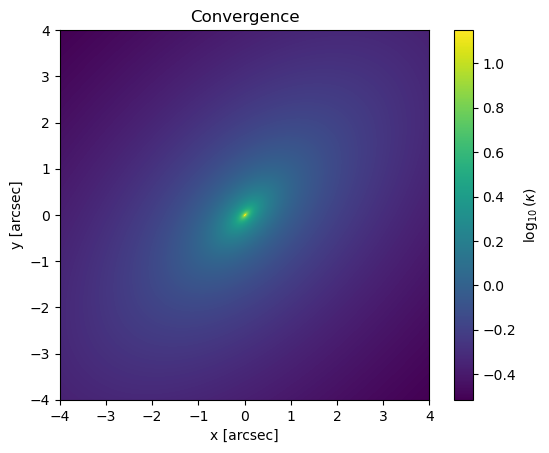

In [85]:
# Define the lens model - EPL + SHEAR

lens_model = LensModel(lens_model_list=[
                                        'EPL', 
                                        # 'SHEAR',
                                        # 'NFW'
                                        ])

kwargs_lens = [
    {'theta_E': 1.8, 'e1': 0, 'e2': 0.3, 'center_x': 0, 'center_y': 0, 'gamma': 1.58}, # EPL
#   {'gamma1': 0.03, 'gamma2': 0} # shear
    # {"Rs":1, "alpha_Rs":1, "center_x":0, "center_y":0} # NFW
               ]

x_grid, y_grid = np.linspace(-4, 4, 400), np.linspace(-4, 4, 400)
x_coords, y_coords = np.meshgrid(x_grid, y_grid)

kappa_on_grid = lens_model.kappa(x_coords, y_coords, kwargs_lens)

plt.figure()
plt.title('Convergence')
plt.imshow(np.log10(kappa_on_grid), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)], 
           origin='lower')
c = plt.colorbar()
c.set_label('$\\log_{10}(\\kappa)$')
plt.xlabel('x [arcsec]')
plt.ylabel('y [arcsec]')


In [86]:
def lensing_potential_with_fft(x_coords, y_coords, kappa_on_grid):
    # first make the grid in Fourier space
    delta_x = x_coords[0, 1] - x_coords[0, 0]
    delta_y = y_coords[1, 0] - y_coords[0, 0]
    k_x = np.fft.fftfreq(x_coords.shape[1], delta_x)
    k_y = np.fft.fftfreq(y_coords.shape[0], delta_y)
    k_x_grid, k_y_grid = np.meshgrid(k_x, k_y)
    k_sq_grid = k_x_grid**2 + k_y_grid**2
    k_sq_grid[0, 0] = 1  # avoid division by zero

    # FFT of the convergence
    kappa_fft = np.fft.fft2(kappa_on_grid)

    # lensing potential in Fourier space
    phi_fft = -2 * kappa_fft / k_sq_grid

    # inverse FFT to real space
    phi_on_grid = np.fft.ifft2(phi_fft).real

    return phi_on_grid

def alpha_from_potential(phi_on_grid, x_coords, y_coords):
    alpha_x = np.gradient(phi_on_grid, axis=1) / (x_coords[0, 1] - x_coords[0, 0])
    alpha_y = np.gradient(phi_on_grid, axis=0) / (y_coords[1, 0] - y_coords[0, 0])
    return alpha_x, alpha_y

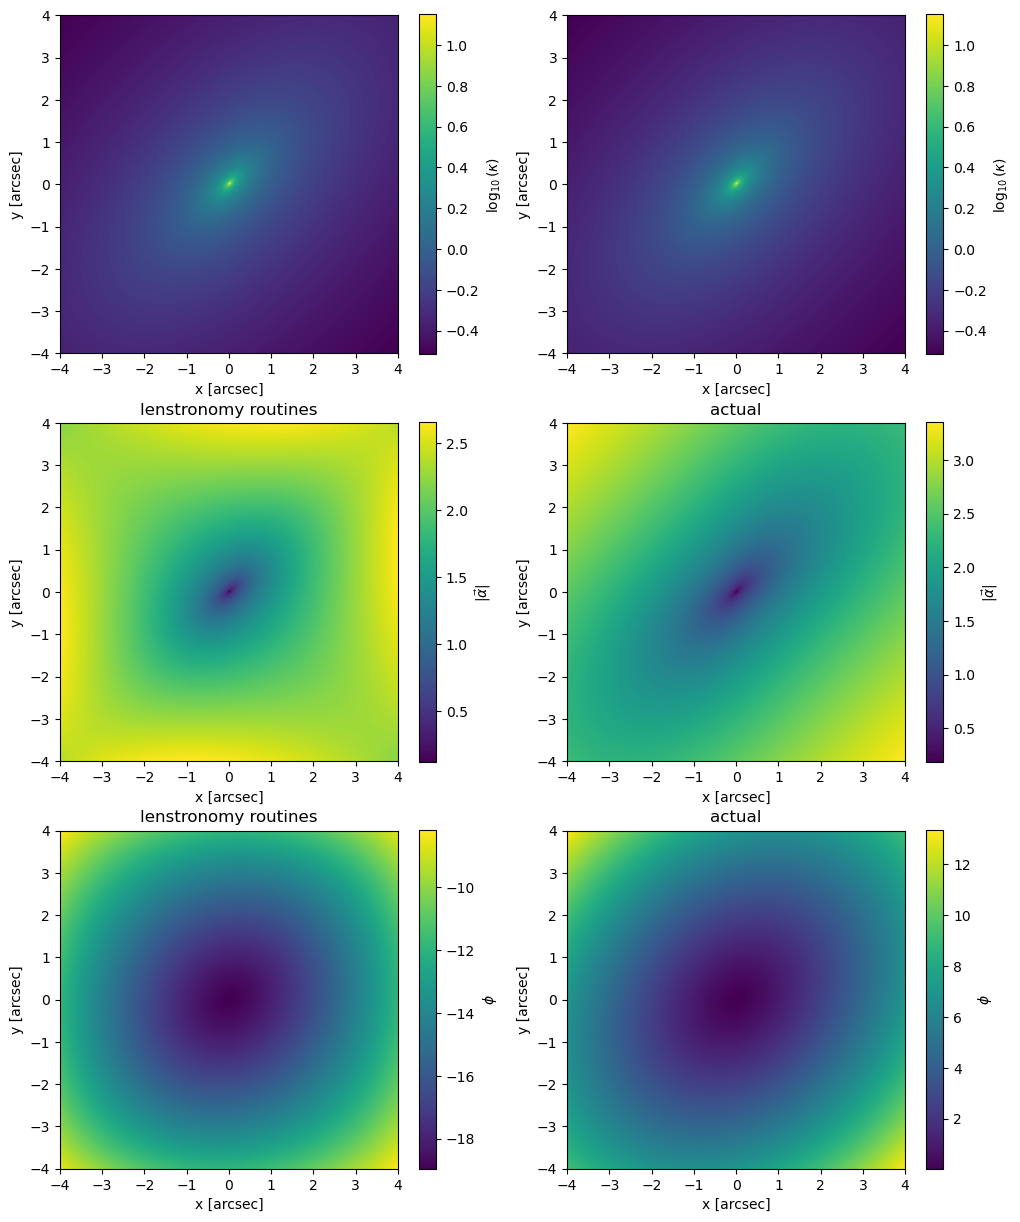

In [87]:
phi = potential_from_kappa_grid(kappa_on_grid, grid_spacing=x_coords[0, 1] - x_coords[0, 0])

alpha_x, alpha_y = deflection_from_kappa_grid(kappa_on_grid, grid_spacing=x_coords[0, 1] - x_coords[0, 0])

fig, ax = plt.subplots(3, 2, figsize=(12, 15))

# Convergence
# ax[0, 0].set_title('lenstronomy routines')
# ax[0, 1].set_title('actual')
ax[0, 0].imshow(np.log10(kappa_on_grid), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)], 
                origin='lower')
ax[0, 1].imshow(np.log10(kappa_on_grid), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[0, 0].set_xlabel('x [arcsec]')
ax[0, 0].set_ylabel('y [arcsec]')
ax[0, 1].set_xlabel('x [arcsec]')
ax[0, 1].set_ylabel('y [arcsec]')
c = ax[0, 0].figure.colorbar(ax[0, 0].images[0], ax=ax[0, 0])
c.set_label('$\\log_{10}(\\kappa)$')
c = ax[0, 1].figure.colorbar(ax[0, 1].images[0], ax=ax[0, 1])
c.set_label('$\\log_{10}(\\kappa)$')

# Deflection angles
lenstronomy_alpha_x, lenstronomy_alpha_y = lens_model.alpha(x_coords, y_coords, kwargs_lens)
ax[1, 0].set_title('lenstronomy routines')
ax[1, 1].set_title('actual')
ax[1, 0].imshow(np.sqrt(alpha_x**2 + alpha_y**2), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[1, 1].imshow(np.sqrt(lenstronomy_alpha_x**2 + lenstronomy_alpha_y**2), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[1, 0].set_xlabel('x [arcsec]')
ax[1, 0].set_ylabel('y [arcsec]')
ax[1, 1].set_xlabel('x [arcsec]')
ax[1, 1].set_ylabel('y [arcsec]')
c = ax[1, 0].figure.colorbar(ax[1, 0].images[0], ax=ax[1, 0])
c.set_label('$|\\vec{\\alpha}|$')
c = ax[1, 1].figure.colorbar(ax[1, 1].images[0], ax=ax[1, 1])
c.set_label('$|\\vec{\\alpha}|$')   

# Lensing potential
ax[2, 0].set_title('lenstronomy routines')
ax[2, 1].set_title('actual')
ax[2, 0].imshow(phi, extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)], 
                origin='lower')
ax[2, 1].imshow(lens_model.potential(x_coords, y_coords, kwargs_lens), extent=[np.min(x_grid), np.max(x_grid), np.min(y_grid), np.max(y_grid)],
                origin='lower')
ax[2, 0].set_xlabel('x [arcsec]')
ax[2, 0].set_ylabel('y [arcsec]')
ax[2, 1].set_xlabel('x [arcsec]')
ax[2, 1].set_ylabel('y [arcsec]')
c = ax[2, 0].figure.colorbar(ax[2, 0].images[0], ax=ax[2, 0])
c.set_label('$\\phi$')
c = ax[2, 1].figure.colorbar(ax[2, 1].images[0], ax=ax[2, 1])
c.set_label('$\\phi$')

Again, there is slight deviation from the analytical solution at the edges of the grid.